Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Training an Object Detection model using AutoML
In this notebook, we go over how you can use AutoML for training an Object Detection model. We will use a small dataset to train the model, demonstrate how you can tune hyperparameters of the model to optimize model performance and deploy the model to use in inference scenarios.

## Setup
To use this notebook, you will need to install the private preview package for AutoML for images from the private index.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1"  --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_vision_private_preview/"

### Licensing Information - 
This preview software is made available to you on the condition that you agree to
[your agreement][1] governing your use of Azure, and to the Supplemental Terms of Use for Microsoft Azure Previews[2], which supplement your agreement governing your use of Azure.
If you do not have an existing agreement governing your use of Azure, you agree that 
your agreement governing use of Azure is the [Microsoft Online Subscription Agreement][3]
(which incorporates the [Online Services Terms][4]).
By using the software you agree to these terms. This software may collect data
that is transmitted to Microsoft. Please see the [Microsoft Privacy Statement][5]
to learn more about how Microsoft processes personal data.

[1]: https://azure.microsoft.com/en-us/support/legal/
[2]: https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/
[3]: https://azure.microsoft.com/en-us/support/legal/subscription-agreement/
[4]: http://www.microsoftvolumelicensing.com/DocumentSearch.aspx?Mode=3&DocumentTypeId=46
[5]: http://go.microsoft.com/fwlink/?LinkId=248681 


## Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [ ]:
## specify workspace parameters
#subscription_id='<my-subscription-id>'   
#resource_group='<my-resource-group>'   
#workspace_name='<my-workspace-name>'

from azureml.core.workspace import Workspace
ws = Workspace.create(name=workspace_name,
                      subscription_id=subscription_id,
                      resource_group=resource_group, 
                      exist_ok=True)

## Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training. AutoML models for image tasks require GPU SKUs and support NC and ND families. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [ ]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-cluster-nc6"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6', 
                                                           idle_seconds_before_scaledown=1800,
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

## Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [ ]:
from azureml.core import Experiment

experiment_name = 'automl-vision-notebook' 
experiment = Experiment(ws, name=experiment_name)

## Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

In this notebook, we use a toy dataset called Fridge Objects, which consists of 128 images of 4 classes of beverage container {can, carton, milk bottle, water bottle} photos taken on different backgrounds. We first download and unzip the data locally.

In [ ]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = 'https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip'
data_file = './odFridgeObjects.zip'
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, 'r') as zip:
    print('extracting files...')
    zip.extractall()
    print('done')
    
# delete zip file
os.remove(data_file)

This is a sample image from this dataset:

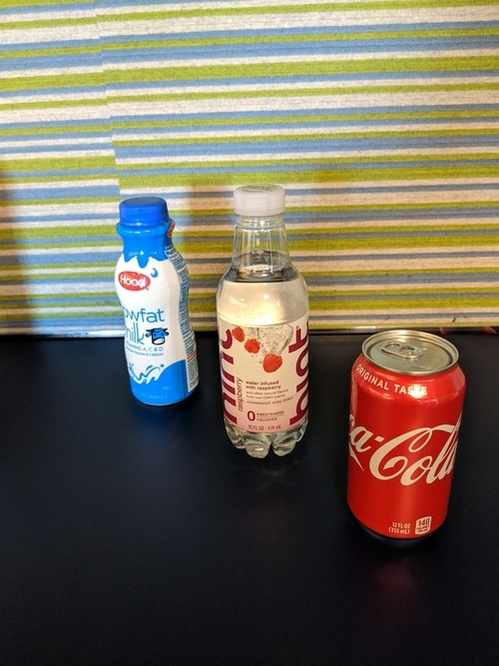

In [23]:
from IPython.display import Image
Image(filename='./odFridgeObjects/images/31.jpg') 

### Convert the downloaded data to JSONL
In this example, the fridge object dataset is annotated in Pascal VOC format, where each image corresponds to an xml file. Each xml file contains information on where its corresponding image file is located and also contains information about the bounding boxes and the object labels. In order to use this data to create an AzureML Datset, we first need to convert it to the required JSONL format.

The following script is creating two .jsonl files (one for training and one for validation) in the parent folder of the dataset. The train / validation ratio corresponds to 20% of the data going into the validation file.

In [ ]:
import json
import os
import xml.etree.ElementTree as ET

src = "./odFridgeObjects/"
train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the annotations
annotations_folder = os.path.join(src, "annotations")

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = \
    {
        "image_url": "AmlDatastore://" + workspaceblobstore + "/"
                     + os.path.basename(os.path.dirname(src)) + "/" + "images",
        "image_details": {"format": None, "width": None, "height": None},
        "label": []
    }

# Read each annotation and convert it to jsonl line
with open(train_annotations_file, 'w') as train_f:
    with open(validation_annotations_file, 'w') as validation_f:
        for i, filename in enumerate(os.listdir(annotations_folder)):
            if filename.endswith(".xml"):
                print("Parsing " + os.path.join(src, filename))

                root = ET.parse(os.path.join(annotations_folder, filename)).getroot()

                width = int(root.find('size/width').text)
                height = int(root.find('size/height').text)

                labels = []
                for object in root.findall('object'):
                    name = object.find('name').text
                    xmin = object.find('bndbox/xmin').text
                    ymin = object.find('bndbox/ymin').text
                    xmax = object.find('bndbox/xmax').text
                    ymax = object.find('bndbox/ymax').text
                    isCrowd = int(object.find('difficult').text)
                    labels.append({"label": name,
                                   "topX": float(xmin)/width,
                                   "topY": float(ymin)/height,
                                   "bottomX": float(xmax)/width,
                                   "bottomY": float(ymax)/height,
                                   "isCrowd": isCrowd})
                # build the jsonl file
                image_filename = root.find("filename").text
                _, file_extension = os.path.splitext(image_filename)
                json_line = dict(json_line_sample)
                json_line["image_url"] = json_line["image_url"] + "/" + image_filename
                json_line["image_details"]["format"] = file_extension[1:]
                json_line["image_details"]["width"] = width
                json_line["image_details"]["height"] = height
                json_line["label"] = labels

                if i % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
            else:
                print("Skipping unknown file: {}".format(filename))



### Upload the JSONL file and images to Datastore  
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data, and interact with it from your remote compute targets. It is an abstraction over Azure Storage.



In [ ]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir='./odFridgeObjects', target_path='odFridgeObjects')

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [ ]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'odFridgeObjectsTrainingDataset'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.OBJECT_DETECTION, path=ds.path('odFridgeObjects/train_annotations.jsonl'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)
    
# create validation dataset
validation_dataset_name = "odFridgeObjectsValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)
else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.OBJECT_DETECTION, path=ds.path('odFridgeObjects/validation_annotations.jsonl'))
    validation_dataset = validation_dataset.register(workspace=ws, name=validation_dataset_name)
    
    
print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Validation dataset is optional. If no validation dataset is specified, 20% of your training data will be used for validation.  

This is what the training dataset looks like

In [ ]:
training_dataset.to_pandas_dataframe()

## Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the 'AutoMLVisionConfig'. 

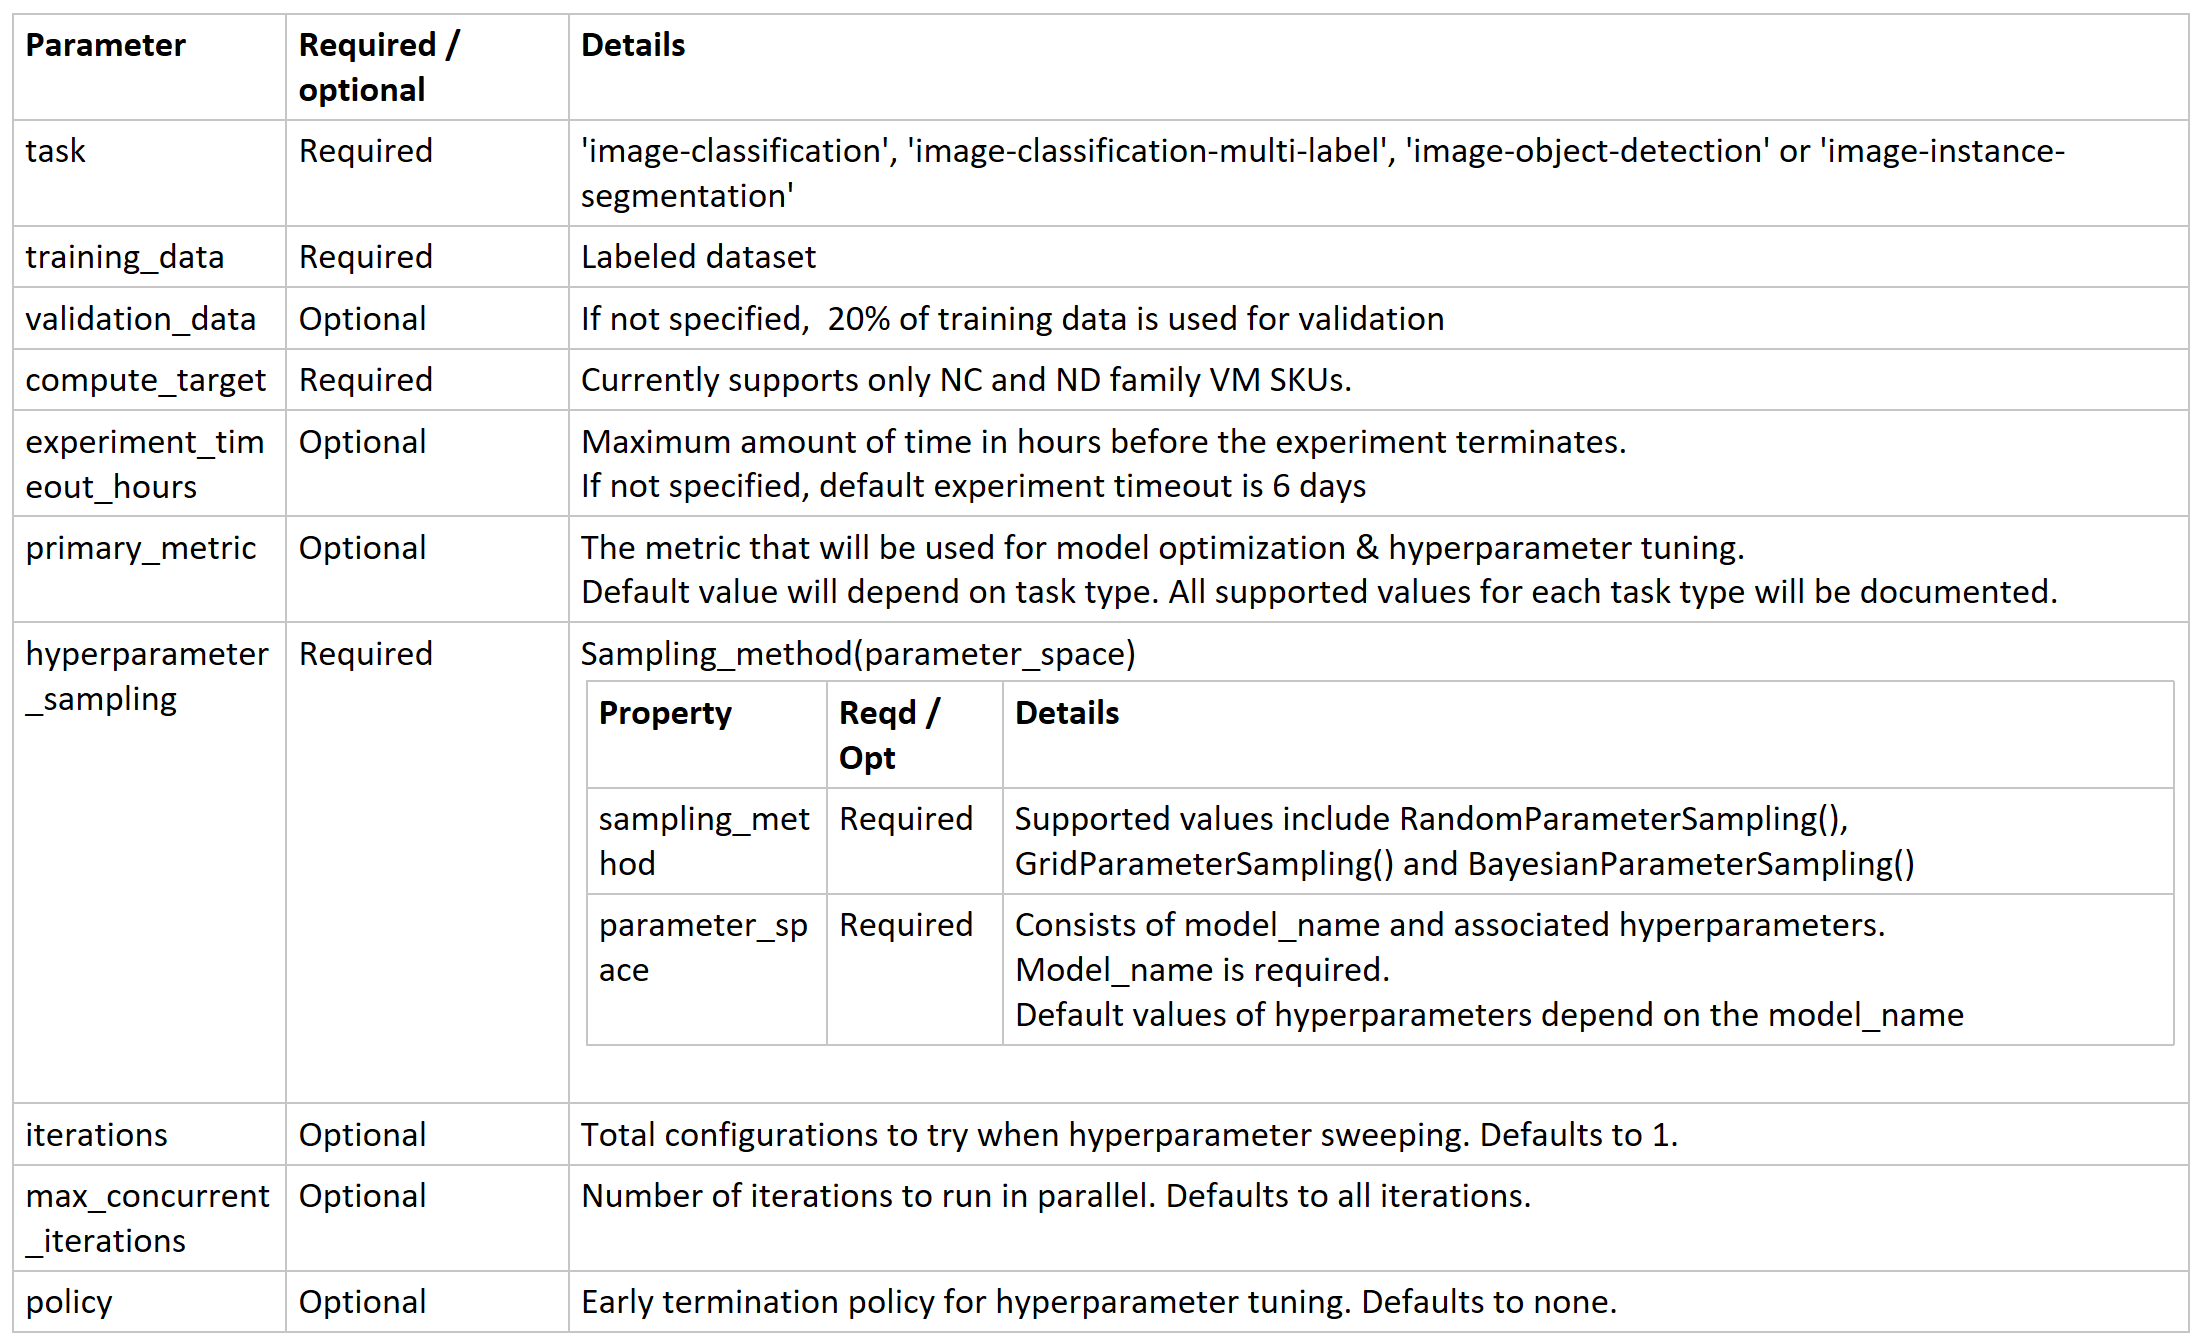

When using AutoML for computer vision tasks, you need to specify the model algorithms using the model_name parameter. You can either specify a single model or choose between multiple.   
### Currently supported model algorithms:
<ul>
<li><b>Image Classification (multi-class and multi-label):</b> 'resnet18', 'resnet34', 'resnet50', 'mobilenetv2', 'seresnext'</li>
<li><b>Object Detection: </b>'yolov5', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet34_fpn', 'fasterrcnn_resnet18_fpn', 'retinanet_resnet50_fpn'</li>
<li><b>Instance segmentation: </b>'maskrcnn_resnet50_fpn'</li>
</ul>

### Hyperparameter sweeping for your AutoML models for computer vision tasks
In this example, we use the AutoMLVisionConfig to train an Object Detection model using yolov5 and fasterrcnn_resnet50_fpn, both of which are pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When using AutoML for computer vision, you can perform a hyperparameter sweep over a defined parameter space, to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for learning_rate, optimizer, lr_scheduler, etc, to generate a model with the optimal 'accuracy'. If hyperparameter values are not specified, then default values are used for the specified algorithm.  

We use Random Sampling to pick samples from this parameter space and try a total of 20 iterations with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes.  

We also leverage the Bandit early termination policy that terminates poor performing configs (those that are not within 20% slack of the best perfroming config), thus significantly saving compute resources.

In [ ]:
from azureml.train.automl import AutoMLVisionConfig
from azureml.train.hyperdrive import GridParameterSampling, RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    'model': choice(
        {
            'model_name': choice('yolov5'),
            'learning_rate': uniform(0.0001, 0.01),
            #'model_size': choice('small', 'medium'), # model-specific
            'img_size': choice(640, 704, 768), # model-specific
        },
        {
            'model_name': choice('fasterrcnn_resnet50_fpn'),
            'learning_rate': uniform(0.0001, 0.001),
            #'warmup_cosine_lr_warmup_epochs': choice(0, 3),
            'optimizer': choice('sgd', 'adam', 'adamw'),
            'min_size': choice(600, 800, 1000), # model-specific
        }
    )
}

tuning_settings = {
    'iterations': 20, 
    'max_concurrent_iterations': 4, 
    'hyperparameter_sampling': RandomParameterSampling(parameter_space),  
    'policy': BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6),
    'scenario': 'Vision-Candidate' # Only needed until cond. HP changes are in prod
}


automl_vision_config = AutoMLVisionConfig(task='image-object-detection',
                                          compute_target=compute_target,
                                          training_data=training_dataset,
                                          validation_data=validation_dataset,
                                          primary_metric='mean_average_precision',
                                          **tuning_settings)

### Using default hyperparameter values for the specified algorithm
In the example above, we saw how you can perfrom a hyperparameter sweep across multiple model algorithms for computer vision tasks using AutoML. If instead, you wish to use the default hyperparameter values for a given algorithm (say yolov5), you can specify the config for your Vision runs as follows -

In [ ]:
automl_vision_config_default_yolov5 = AutoMLVisionConfig(
                                          task='image-object-detection',
                                          compute_target=compute_target,
                                          training_data=training_dataset,
                                          validation_data=validation_dataset,
                                          hyperparameter_sampling=GridParameterSampling({'model_name': choice('yolov5')}),
                                          scenario="Vision-Candidate")

## Submitting an AutoML run for Computer Vision tasks 
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset and generate the optimal model for your scenario.

In [ ]:
from azureml.core import Environment
import urllib
import json
download_url = 'https://curatedenvironments.blob.core.windows.net/prerelease/Candidate/AzureML-AutoML-DNN-Vision-GPU/envdef.json'
data_file = './envdef.json'
urllib.request.urlretrieve(download_url, filename=data_file)
with open(data_file, 'r') as env_f:
    e = json.loads(env_f.read())
    e['name'] = "AutoML-DNN-Vision-GPU-Candidate"
    
automl_env = './azureml_environment.json'
with open(automl_env, 'w') as automl_env_f:
    automl_env_f.write(json.dumps(e))
    
env = Environment.load_from_directory('.')
env.register(ws)

In [ ]:
automl_vision_run = experiment.submit(automl_vision_config)

In [ ]:
automl_vision_run.wait_for_completion(wait_post_processing=True)

## Register the optimal vision model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [ ]:
# Register the model from the best run

best_child_run = automl_vision_run.get_best_child()
model_name = best_child_run.properties['model_name']
model = best_child_run.register_model(model_name = model_name, model_path='outputs/model.pt')

## Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage.  
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster, or use an existing AKS cluster.

In [ ]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "cluster-aks-gpu"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="eastus2")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)

    aks_target.wait_for_completion(show_output=True)

Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [ ]:
# Deploy the model from the best run as an AKS web service
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                    cpu_cores=1,
                                                    memory_gb=50,
                                                    enable_app_insights=True)

aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name='automl-vision-test',
                           overwrite=True)
aks_service.wait_for_deployment(show_output=True)
print(aks_service.state)

## Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image. In this case, we'll use a random image from the dataset and pass it to te scoring URI.

In [ ]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

sample_image = './test_image.jpg'

# Load image data
data = open(sample_image, 'rb').read()

# Set the content type
headers = {'Content-Type': 'application/octet-stream'}

# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print(resp.text)

## Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib

<Figure size 1296x864 with 0 Axes>

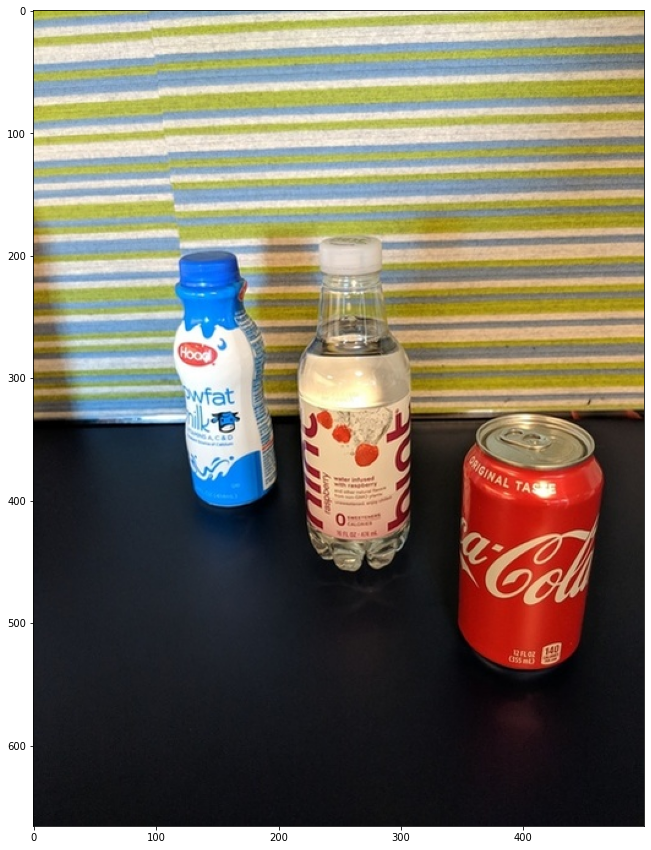

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection 
detections = json.loads(resp.text)
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = np.random.rand(3) #'red'
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')

        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)

plt.show()